## Handwritten Numbers Classification using NN
### Architecture
- Input Layer -> (28*28, 784)
- fc1 -> (784, 512, LeakyReLU)
- bn1 -> Batch Normalization
- fc2 -> (512, 256, LeakyReLU)
- bn2 -> Batch Normalization
- fc3 -> (256, 128, LeakyReLU)
- bn3 -> Batch Normalization
- fc4 -> (128, 10)
- Dropout Rate: 0.3 (After Each Hidden Layer)

In [3]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt 

In [7]:
# Hyperparams 
batch_size = 64
num_epochs = 10 
learning_rate = 0.001 

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081))
])

# Load MNIST Dataset 
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512) # Batch normalization
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3) # Dropout for regularization 

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing model, loss function, optimizer, and learning_rate 
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

#Training function
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if(i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i+1}, Loss: {running_loss/200:.4f}, Accuracy: {running_acc/200:.4f}')
            running_loss, running_acc = 0.0, 0.0 

In [12]:
# Testing function 
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss, test_acc = 0.0, 0.0 
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)


    avg_loss, avg_acc = test_loss / len(test_loader), test_acc / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}')
    scheduler.step(avg_loss)

In [13]:
# Train and test Loop 
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)

Epoch 1, Batch 200, Loss: 0.5388, Accuracy: 0.8605
Epoch 1, Batch 400, Loss: 0.2718, Accuracy: 0.9231
Epoch 1, Batch 600, Loss: 0.2137, Accuracy: 0.9366
Epoch 1, Batch 800, Loss: 0.1994, Accuracy: 0.9409
Test Loss: 0.1061, Test Accuracy: 0.9666
Epoch 2, Batch 200, Loss: 0.1585, Accuracy: 0.9504
Epoch 2, Batch 400, Loss: 0.1523, Accuracy: 0.9549
Epoch 2, Batch 600, Loss: 0.1540, Accuracy: 0.9545
Epoch 2, Batch 800, Loss: 0.1428, Accuracy: 0.9564
Test Loss: 0.0758, Test Accuracy: 0.9770
Epoch 3, Batch 200, Loss: 0.1178, Accuracy: 0.9646
Epoch 3, Batch 400, Loss: 0.1193, Accuracy: 0.9649
Epoch 3, Batch 600, Loss: 0.1114, Accuracy: 0.9658
Epoch 3, Batch 800, Loss: 0.1073, Accuracy: 0.9663
Test Loss: 0.0648, Test Accuracy: 0.9787
Epoch 4, Batch 200, Loss: 0.1010, Accuracy: 0.9681
Epoch 4, Batch 400, Loss: 0.1039, Accuracy: 0.9687
Epoch 4, Batch 600, Loss: 0.1085, Accuracy: 0.9652
Epoch 4, Batch 800, Loss: 0.0959, Accuracy: 0.9709
Test Loss: 0.0694, Test Accuracy: 0.9770
Epoch 5, Batch 200, 

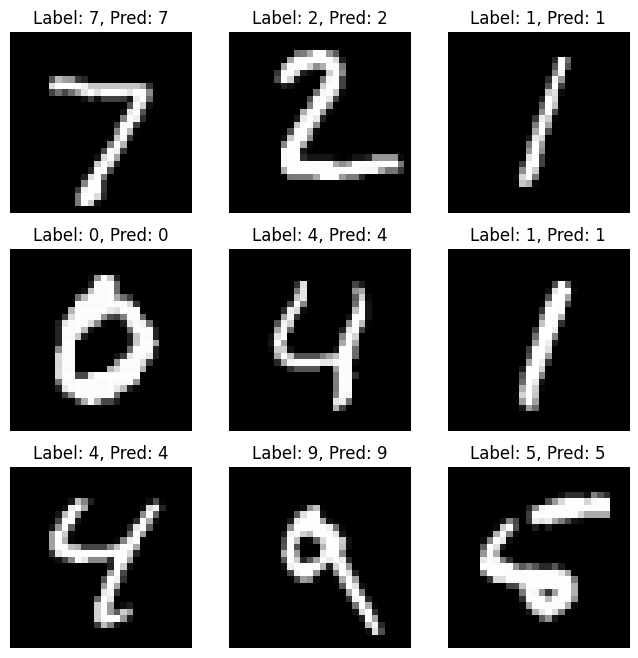

In [14]:
# Visualizing the predictions 
def visualize_predictions():
    model.eval()
    samples, labels = next(iter(test_loader))
    samples = samples.to(device)
    outputs = model(samples)
    _, preds = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i]}, Pred: {preds[i]}')
        ax.axis('off')
    plt.show()

visualize_predictions()